# Galaxy Surface brightness + Error of the flux measurement

#### Remember to change the attenuation each time you change the filter

In [14]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry
from astropy.visualization import simple_norm
from photutils.profiles import RadialProfile , CurveOfGrowth
import sep
from scipy.ndimage import gaussian_filter1d
import pandas as pd

# A&A specific settings
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"], # A&A uses a Times-based font
    "axes.labelsize": 20,    # Standard size for A&A captions/labels
    "font.size": 20,
    "legend.fontsize": 20,
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
    "text.latex.preamble": r"\usepackage{txfonts}" # This matches the A&A math style
})

path_galaxy = "Bicocca-Tele.data/ngc_6946_for_29th_Sep_2025/LIGHT"
with fits.open(path_galaxy + "/master_galaxy_G.fits") as hdu:  # change the attenuation and the calibration constant also N_exp..........
    data = hdu[0].data               # Units are in erg/s/cm^2  / e-17

data_a = data.astype(data.dtype.newbyteorder('='))
A_r = 4.12
A_g = 5.5
data = data_a*(1e-17)*10**(A_g/2.5)    # Removing the attenuation and the units are in erg/sec/cm^2. I will not remove the attenuation now.

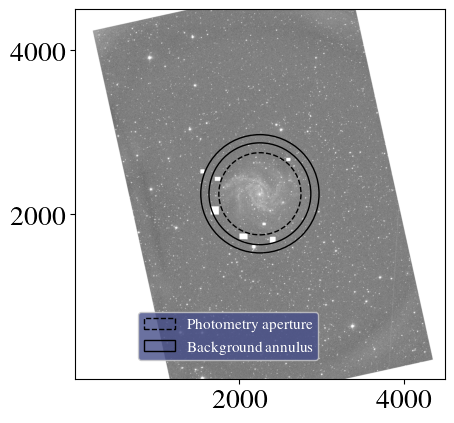

In [15]:
position_x , position_y = 2250 ,  2250
position = (position_x,position_y)
aperture = CircularAperture(position, r= 500)
annulus_aperture = CircularAnnulus(position, r_in=620, r_out=720)


mask = np.zeros(data.shape , dtype= bool)
mask[ 1870:1900 , 2280:2320 ] = True
mask[ 1590:1630 , 2155:2195 ] = True
mask[ 1655:1730 , 2370:2440 ] = True
mask[ 2650:2690 , 2570:2620 ] = True
mask[ 1700:1770 , 2000:2099 ] = True
mask[ 2410:2459 , 1700:1770 ] = True
mask[ 2500:2550 , 1525:1575 ] = True
mask[ 2000:2100 , 1650:1750 ] = True

data = np.ma.array(data, mask=mask) # Applying the mask on data
cmap = plt.cm.gray.copy()   # These 2 lines are to show the masked stars
cmap.set_bad('white')

norm = simple_norm(data, 'sqrt', percent = 99)
plt.imshow(data, cmap= cmap , norm=norm, origin = 'lower')
plt.xticks([2000,4000])
plt.yticks([2000,4000])
ap_patches = aperture.plot(color='black', linestyle = '--', lw=1,
                           label='Photometry aperture')
ann_patches = annulus_aperture.plot(color='black', lw=1,
                                    label='Background annulus')
handles = (ap_patches[0], ann_patches[0])
plt.legend(loc=(0.17, 0.05), facecolor="#454D89", labelcolor='white',
           handles=handles, prop={'weight': 'bold', 'size': 11})
# plt.title('Aperture and Annulus on Galaxy')
plt.show()

The Radial Profile:
* averges all values on the circumeference of each aperture at each radius.
* transform the 2D array into 1D data so we can study the surface brightness from the center of the galaxy

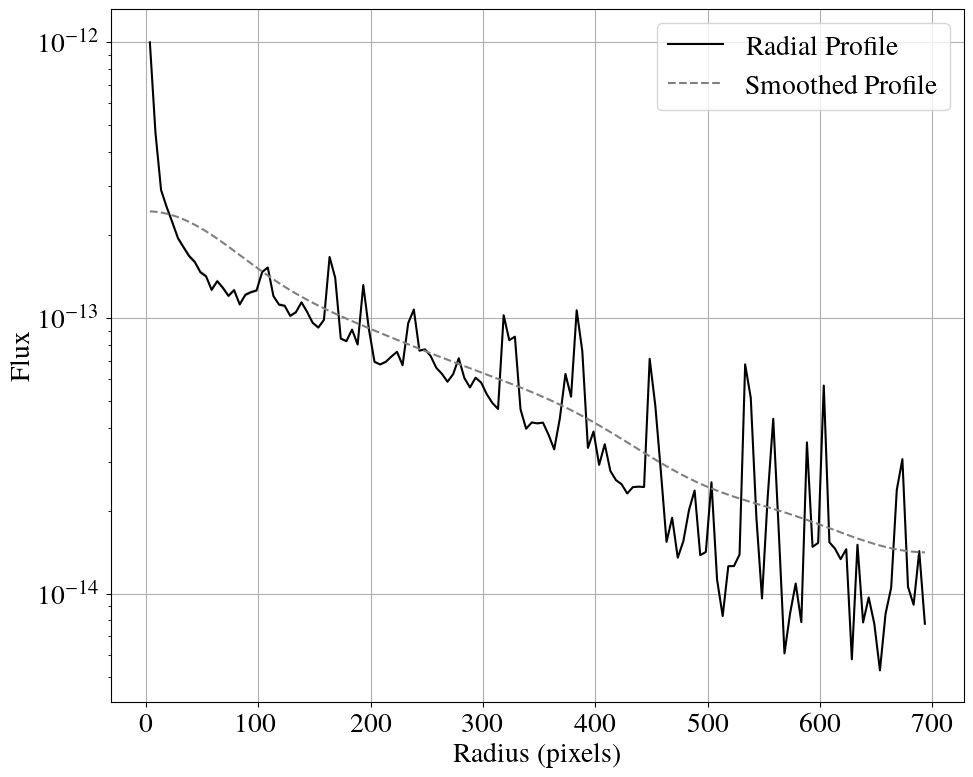

We used the log10 only to show a better plot.


In [16]:
bkg = sep.Background(data.data.astype(np.float64))
rms = bkg.rms()

edge_radii = np.arange(1,700, 5)
rp = RadialProfile(data, position, edge_radii,error = bkg.back() , mask=None)
smooth = gaussian_filter1d(rp.profile, sigma=12)     # Smooth average

# === Plot Radial Profile ===
fig, (ax) = plt.subplots(figsize=(11, 9))
rp.plot(ax=ax, label='Radial Profile', color='black')
rp.plot_error(ax=ax)
ax.plot(rp.radius, smooth, '--', label='Smoothed Profile', color='grey')
ax.set_yscale('log')
# plt.title('Radial Profile')
plt.ylabel('Flux')
ax.legend()
ax.grid()
plt.show()
print('We used the log10 only to show a better plot.')

In [17]:
radius = np.arange(5,800,10)
fluxes = []
for r in radius:
    aperture = CircularAperture(position, r=r)         # Measuring the flux of the selected radius.(The galaxy)
    annulus = annulus_aperture                         # Measuring the sky background which is out of the galaxy range
    phot_table = aperture_photometry(data, [aperture, annulus])   # Sums pixels values of aperture and annulus. Return a table of the sum
    aperture_sum = phot_table['aperture_sum_0'][0]
    annulus_sum = phot_table['aperture_sum_1'][0]
    bkg_per_pix = annulus_sum / annulus.area                # Average background per pixel
    total_bkg = bkg_per_pix * aperture.area                 # estimate background flux inside the aperture
    net_flux = aperture_sum - total_bkg
    fluxes.append(net_flux)                                 # !! Correct flux value!! Check the Sky subtraction file....

### The notch in the plot is due to a combination of stars and we couldn't remove all of them properly

In [18]:
fluxes[49]

np.float64(3.42285642495081e-08)

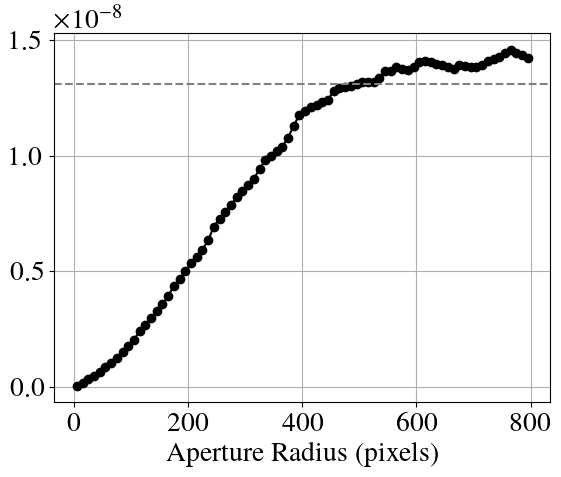

In [6]:
# === Plot curve of growth ===   
plt.plot(radius, fluxes , marker='o', color = 'black')
plt.axhline(y = fluxes[49], linestyle = "--", color = 'grey')
plt.xlabel("Aperture Radius (pixels)")
# plt.ylabel("Flux Growth erg/s/cm^2 ")
# plt.title("Curve of Growth for the galaxy {}".format(position))
plt.grid()
plt.show()

In [19]:
calib_const = {
    "G": {
        "00": 5.30e-17,
        "01": 5.38e-17,
        "02": 5.33e-17
    },
    "R": {
        "00": 5.50e-17,
        "01": 5.49e-17,
        "02": 5.42e-17,
        "03": 5.48e-17
    },
    "I": {
        "01": 4.59e-17,
        "02": 4.64e-17   
    }
}


g_mean = (calib_const["G"]["00"] + calib_const["G"]["01"] + calib_const["G"]["02"])/3
r_mean = (calib_const["R"]["00"] + calib_const["R"]["01"] + calib_const["R"]["02"] + calib_const["R"]["03"])/4
i_mean = (calib_const["I"]["01"] + calib_const["I"]["02"])/2

calib_const_mean = {
    "G":  f"{g_mean}"
    ,
    "R":  f"{r_mean}"
    ,
    "I":  f"{i_mean}"
    }
std_bkg = np.nanstd(bkg)

cc = float(calib_const_mean["G"])
t_exp = 300                            # The exposure time. For the I-band image is 600
N_exp = 3                              # Number of exposures combined in the master frame. The R band has 4, the I has 2, and the g has 3
total_flux = fluxes[49]                # Use the value corresponding to the choosen radius.
radius_tot_flux = radius[49]           # Use the lowest radius where the curve of growth becomes stable
pixel_scale = 0.000153                 # The one from the galaxy projection file.

sigma_flux = np.sqrt(cc* total_flux /(t_exp*N_exp))   # The source or the galaxy error after subtracting the background.

sigma_background = np.sqrt(np.pi * radius_tot_flux**2) * std_bkg  # Pixels_number = np.pi * radius_tot_flux


In [20]:
fluxes[49] 

np.float64(3.42285642495081e-08)

### IMPORTANT NOTE:
* The background error must always dominate as it is the dominant factor in the image.

In [21]:
arr = [[sigma_flux,sigma_background],[(total_flux),np.nanmean(bkg)],[np.nanstd(data),np.nanstd(bkg)]]

print('This schedule is only for comparison \n Remember that the values here are for the g filter')
tot_error = np.sqrt(sigma_flux**2 + sigma_background**2)
print(f"The G total error : {tot_error:.4e}")

pd.DataFrame(arr, columns = ['source data','background'], index = ['error', 'mean','std'])

This schedule is only for comparison 
 Remember that the values here are for the g filter
The G total error : 1.1706e-11


,source data,background
error,4.505138e-14,1.170623e-11
mean,3.422856e-08,1.787963e-15
std,8.183404e-13,1.334249e-14


In [10]:

# medimage = np.nanmedian(data)         # np.nanstd


In [12]:
arr = [[sigma_flux,sigma_background],[(total_flux),np.nanmean(bkg)],[np.nanstd(data),np.nanstd(bkg)]]

print('This schedule is only for comparison \n Remember that the values here are for the g filter')
tot_error = np.sqrt(sigma_flux**2 + sigma_background**2)
print(f"The R total error : {tot_error:.4e}")
pd.DataFrame(arr, columns = ['source data','background'], index = ['error', 'mean','std'])

This schedule is only for comparison 
 Remember that the values here are for the g filter
The R total error : 3.4774e-12


,source data,background
error,2.446085e-14,3.477313e-12
mean,1.312014e-08,4.958866e-16
std,2.601262e-13,3.963361e-15
